# Cox Regression

## Cox Proportional Hazrds Regression

Cox Proportional Hazards (CoxPH) regression is to describe the survival according to several corvariates. The difference between CoxPH regression and Kaplan-Meier curves or the logrank tests is that the latter only focus on modeling the survival according to one factor (categorical predictor is the best) while the former is able to take into consideration any covariates simultaneouly, regardless of whether they're quantitive or categorical. The model is as follows:

$$
h(t) = h_0(t)\exp(\eta).
$$

where,

- $\eta = x\beta.$
- $t$ is the survival time.
- $h(t)$ is the hazard function which evaluates the risk of dying at time $t$.
- $h_0(t)$ is called the baseline hazard. It describes value of the hazard if all the predictors are zero.
- $\beta$ measures the impact of covariates.


Consider two cases $i$ and $i'$ that have different $x$ values. Their hazard function can be simply written as follows

$$
h_i(t) = h_0(t)\exp(\eta_i) = h_0(t)\exp(x_i\beta),
$$

and

$$
h_{i'}(t) = h_0(t)\exp(\eta_{i'}) = h_0(t)\exp(x_{i'}\beta).
$$

The hazard ratio for these two cases is

$$
\begin{aligned}
\frac{h_i(t)}{h_{i'}(t)} & = \frac{h_0(t)\exp(\eta_i)}{h_0(t)\exp(\eta_{i'})} \\
                         & = \frac{\exp(\eta_i)}{\exp(\eta_{i'})},
\end{aligned}
$$

which is independent of time.

## Real Data Example

### Lung Cancer Dataset

We are going to apply best subset selection to the NCCTG Lung Cancer Dataset from [https://www.kaggle.com/ukveteran/ncctg-lung-cancer-data](https://www.kaggle.com/ukveteran/ncctg-lung-cancer-data). 
This dataset consists of survival informatoin of patients with advanced lung cancer from the North Central Cancer Treatment Group. The proportional hazards model allows the analysis of survival data by regression modeling. Linearity is assumed on the log scale of the hazard. The hazard ratio in Cox proportional hazard model is assumed constant. 

First, we load the data.

In [1]:
import pandas as pd 

data = pd.read_csv('./cancer.csv')
data = data.drop(data.columns[[0, 1]], axis = 1)
print(data.head())

   time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  wt.loss
0   306       2   74    1      1.0      90.0      100.0    1175.0      NaN
1   455       2   68    1      0.0      90.0       90.0    1225.0     15.0
2  1010       1   56    1      0.0      90.0       90.0       NaN     15.0
3   210       2   57    1      1.0      90.0       60.0    1150.0     11.0
4   883       2   60    1      0.0     100.0       90.0       NaN      0.0


Then we remove the rows containing any missing data. After that, we have a total of 168 observations.

In [2]:
data = data.dropna()
print(data.shape)

(168, 9)


Then we change the factors `ph.ecog` into dummy variables:

In [3]:
data['ph.ecog'] = data['ph.ecog'].astype("category")
data = pd.get_dummies(data)
data = data.drop('ph.ecog_0.0', axis = 1)
print(data.head())

   time  status  age  sex  ph.karno  pat.karno  meal.cal  wt.loss  \
1   455       2   68    1      90.0       90.0    1225.0     15.0   
3   210       2   57    1      90.0       60.0    1150.0     11.0   
5  1022       1   74    1      50.0       80.0     513.0      0.0   
6   310       2   68    2      70.0       60.0     384.0     10.0   
7   361       2   71    2      60.0       80.0     538.0      1.0   

   ph.ecog_1.0  ph.ecog_2.0  ph.ecog_3.0  
1            0            0            0  
3            1            0            0  
5            1            0            0  
6            0            1            0  
7            0            1            0  


We split the dataset into a training set and a test set. The model is going to be built on the training set and later we will test the model performance on the test set.

In [4]:
import numpy as np
np.random.seed(0)

ind = np.linspace(1, 168, 168) <= round(168*2/3)
train = np.array(data[ind])
test = np.array(data[~ind])

print('train size: ', train.shape[0])
print('test size:', test.shape[0])

train size:  112
test size: 56


### Model Fitting

The `CoxPHSurvivalAnalysis()` function in the `abess` package allows us to perform best subset selection in a highly efficient way. 

By default, the function implements the abess algorithm with the support size (sparsity level) changing from 0 to $\min\{p,n/log(n)p \}$ and the best support size is determined by EBIC. You can change the tunging criterion by specifying the argument `ic_type` and the support size by `support_size`. The available tuning criteria now are `gic`, `aic`, `bic`, `ebic`. Here we give an example.

In [5]:
from abess import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(ic_type = 'gic')
model.fit(train[:, 2:], train[:, :2])

abessCox(ic_type='gic')

After fitting, the coefficients are stored in `model.coef_`, and the non-zero values indicate the variables used in our model.

In [6]:
print(model.coef_)

[ 0.         -0.379564    0.02248522  0.          0.          0.
  0.43729712  1.42127851  2.42095755]


This result shows that 4 variables (the 2nd, 3rd, 7th, 8th, 9th) are chosen into the Cox model. Then a further analysis can be based on them. 

### More on the results

Hold on, we haven’t finished yet. After getting the estimator, we can further do more exploring work. For example, we can use some generic steps to quickly draw some information of those estimators.

Simply fix the `support_size` in different levels, we can plot a path of coefficients like: 

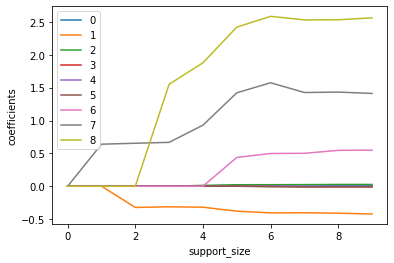

In [7]:
import matplotlib.pyplot as plt

coef = np.zeros((10, 9))
ic = np.zeros(10)
for s in range(10):
    model = CoxPHSurvivalAnalysis(support_size = s, ic_type = 'gic')
    model.fit(train[:, 2:], train[:, :2])
    coef[s, :] = model.coef_
    ic[s] = model.ic_

for i in range(9):
    plt.plot(coef[:, i], label = i)

plt.xlabel('support_size')
plt.ylabel('coefficients')
plt.legend()
plt.show()

Or a view of evolution of information criterion:

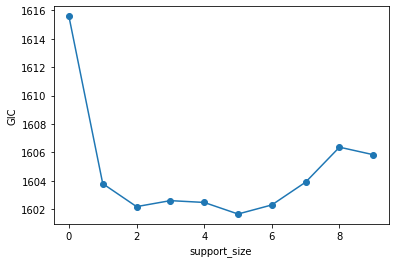

In [8]:
plt.plot(ic, 'o-')
plt.xlabel('support_size')
plt.ylabel('GIC')
plt.show()

Prediction is allowed for all the estimated model. Just call `predict()` function under the model you are interested in. The values it return are $\exp(\eta)=\exp(x\beta)$, which is part of Cox PH hazard function.

Here we give the prediction on the `test` data.

In [9]:
pred = model.predict(test[:, 2:])
print(pred)

[11.0015887  11.97954111  8.11705612  3.32130081  2.9957487   3.23167938
  5.88030263  8.83474265  6.94981468  2.79778448  4.80124013  8.32868839
  6.18472356  7.36597245  2.79540785  7.07729092  3.57284073  6.95551265
  3.59051464  8.73668805  3.51029827  4.28617052  5.21830511  5.11465146
  2.92670651  2.31996184  7.04845409  4.30246362  7.14805341  3.83570919
  6.27832924  6.54442227  8.39353611  5.41713824  4.17823079  4.01469621
  8.99693705  3.98562593  3.9922459   2.79743549  3.47347931  4.40471703
  6.77413094  4.33542254  6.62834299  9.99006885  8.1177072  20.28383502
 14.67346807  2.27915833  5.78151822  4.31221688  3.25950636  6.99318596
  7.4368521   3.86339324]


With these predictions, we can compute the hazard ratio between every two observations (by dividing their values). And, we can also compute the C-Index for our model, i.e., the probability that, for a pair of randomly chosen comparable samples, the sample with the higher risk prediction will experience an event before the other sample or belong to a higher binary class. 

In [20]:
from sksurv.metrics import concordance_index_censored
cindex = concordance_index_censored(test[:, 1] == 2, test[:, 0], pred)
print(cindex[0])

0.6839080459770115


On this dataset, the C-index is about 0.68.

## R tutorial

For R tutorial, please view [https://abess-team.github.io/abess/articles/v05-coxreg.html](https://abess-team.github.io/abess/articles/v05-coxreg.html).